# Removing MR-related artifact from electrophysiological data
Acquired during either a single-echo, simultaneous multislice EPI scan or a multi-echo, simultaneous multislice EPI scan collected while participants performed tasks and watched movies in a 3T Siemens PRISMA scanner.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import bioread as br
from matplotlib.ticker import FormatStrFormatter


from glob import glob
import scipy.signal as signal
from sklearn.metrics import normalized_mutual_info_score, pairwise_distances, pairwise_distances_chunked
#from tslearn.metrics import dtw

In [2]:
import scipy
print('SciPy version', scipy.__version__)

import numpy
print('Numpy version', numpy.__version__)

import pandas
print('Pandas version', pandas.__version__)

import bioread
print('bioread version', bioread.__version__)

import sys 
print("Python version", sys.version) 

SciPy version 1.5.1
Numpy version 1.19.0
Pandas version 1.0.5
bioread version 1.0.4
Python version 3.7.8 (v3.7.8:4b47a5b6ba, Jun 27 2020, 04:47:50) 
[Clang 6.0 (clang-600.0.57)]


Creating color palette...

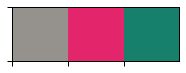

In [3]:
sns.set_context('paper', font_scale=3)

pal = sns.crayon_palette(['Gray', 'Razzmatazz', 'Tropical Rain Forest'])
sns.set_palette(pal)
sns.palplot(pal)

## Here, we use `scipy.signal` functions to assemble various digital filters

In [4]:
pd.options.mode.chained_assignment = None

def consecutive(data, stepsize=0.000501):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def comb_band_stop(notch, filtered, Q, fs):
    max_harmonic = int(nyquist/notch)
    min_harmonic = 1
    for i in np.arange(1, max_harmonic):
        #print(notch * i)
        f0 = notch * i
        w0 = f0/nyquist
        b,a = signal.iirnotch(w0, Q)
        filtered = signal.filtfilt(b, a, filtered)
    j = 1
    while (notch / j) > 1:
        #print(notch * i)
        f0 = notch / i
        w0 = f0/nyquist
        b,a = signal.iirnotch(w0, Q)
        filtered = signal.filtfilt(b, a, filtered)
        j += 1
    return filtered

def fourier_freq(timeseries, d, fmax):
    fft = np.fft.fft(timeseries)
    freq = np.fft.fftfreq(timeseries.shape[-1], d=d)
    fft_db = 10 * np.log10(abs(fft))
    limit = np.where(freq >= fmax)[0][0]
    return fft, fft_db, freq, limit

## And `matplotlib.pyplot` to create a signal plotting function

In [5]:
def plot_signal_fourier(time, data, downsample, limits, fft, freq, lim_fmax, 
                        annotate=False, peaks=None, slice_peaks=None, title=None, save=True):
    gridkw = dict(width_ratios=[2,1])
    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5))
    plt.tight_layout(pad=1.5)

    sns.lineplot(signal.decimate(time, downsample)[limits[0]:limits[1]], 
                 signal.decimate(data, downsample)[limits[0]:limits[1]], 
                 linewidth=1, ax=ax1) #array, top subplot
    sns.lineplot(freq[:lim_fmax], 
                 fft.real[:lim_fmax], 
                 ax=ax2, linewidth=1)#bottom subplot
    if annotate:
        ax2.plot(freq[peaks][:50], fft.real[peaks][:50], "^", ms=5)
        ax2.plot(freq[slice_peaks][:4], fft.real[slice_peaks][:4], "o", ms=7)
    else:
        pass
    ax1.set_xlabel('seconds')
    ax1.set_ylabel('mV')
    ax1.set_yticks([-1,0,1,2])
    ax2.set_xlabel('Hz')
    ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
    ax2.set_ylabel('Power')
    ax1.set_title(title, pad=40)
    ax2.set_title('{0} Frequencies'.format(title),pad=40)
    plt.show()
    if save:
        fig.savefig('../figures/{title}.svg'.format(title=title))
    else:
        pass

# Electrocardiogram data
## Multiband, single-echo EPI sequence
The MBSE sequence used here is the one used by the Adolescent Brain Cognitive Development (ABCD)℠ Study (Casey et al., 2018). 
* 60 transverse slices, with an anterior to posterior phase encoding direction
* TE = 30ms
* TR = 800ms
* MB factor = 6
* Interleaved acquisition

More information about the scan protocols is available with the curated ABCD data via the <a href="https://abcdstudy.org/scientists/protocols/">NIMH Data Archive</a> (NDA)). Participants in the current study (n=2, male, aged 9) completed four 6-minute runs of an emotion regulation task (Blair et al., 2012; Ochsner et al., 2002, 2004) and two 5-minute runs of rest.

In [6]:
#from ABCD sequence
slices = 60
tr = 0.8
mb = 6
cutoff = 120

fs = 2000.

nyquist = fs/2
Q = 100

In [7]:
data_fname = '../data/raw/mbse-raw.csv'
timeseries = pd.read_csv(data_fname, header=0, index_col=0)
basename = data_fname.split('/')[-1][:-4]

if not os.path.exists('../figures'):
    os.mkdir('../figures')

/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
timeseries.head()

,ECG,EDA,Trigger,Resp,seconds,scan
0,0.006104,-0.041199,0.0,-0.002441,0.0000,NaN
1,0.005798,-0.041199,0.0,-0.002441,0.0005,NaN
2,0.006409,-0.039673,0.0,-0.002441,0.0010,NaN
3,0.006104,-0.038147,0.0,-0.002747,0.0015,NaN
4,0.006409,-0.038147,0.0,-0.003052,0.0020,NaN


### Step 0. ECG recording in absence of MR sequence
First, Fourier transform was applied to ECG and EDA data collected both in the presence (`Trigger == 5`) and absence (`Trigger != 5`) of MR pulse sequences to identify the frequencies of MR-related artifacts.

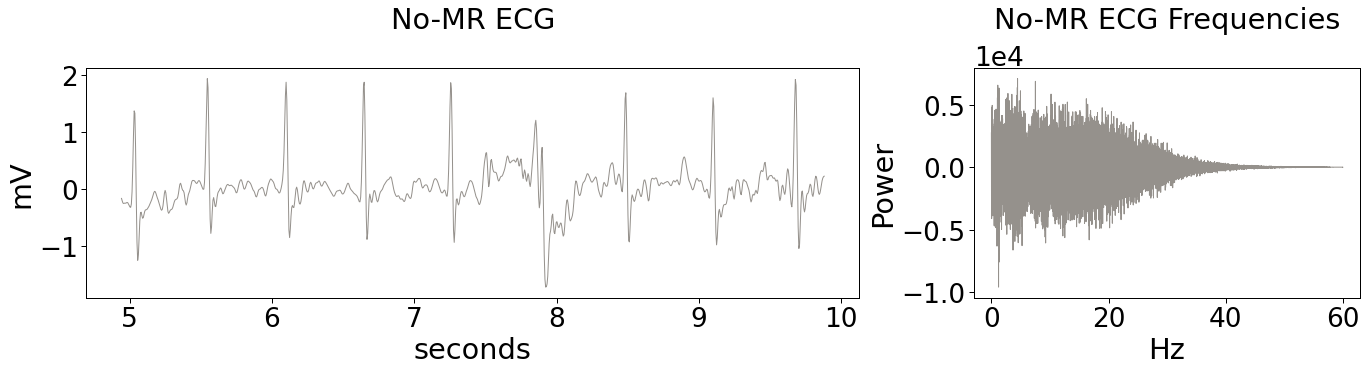

In [9]:
fft_ecg, _, freq, limit = fourier_freq(timeseries[timeseries['Trigger'] != 5]['ECG'][:1000000], 0.0005, 60)
plot_signal_fourier(time=timeseries['seconds'][:200000], 
                    data=timeseries['ECG'][:200000], 
                    downsample=10, 
                    limits=(1000,2000), 
                    fft=fft_ecg, 
                    freq=freq, 
                    lim_fmax=limit, 
                    annotate=False,
                    peaks=None,
                    slice_peaks=None,
                    title='No-MR ECG', 
                    save=True)

### Step 1A. ECG recording in absence of MR sequence
Then, for the purposes of example ECG data collected during the first fMRI scan (`Trigger == 5`) was isolated and Fourier transform was applied to identify the frequencies of MR-related artifacts.

In [10]:
scan1 = timeseries[timeseries['scan'] == 1]

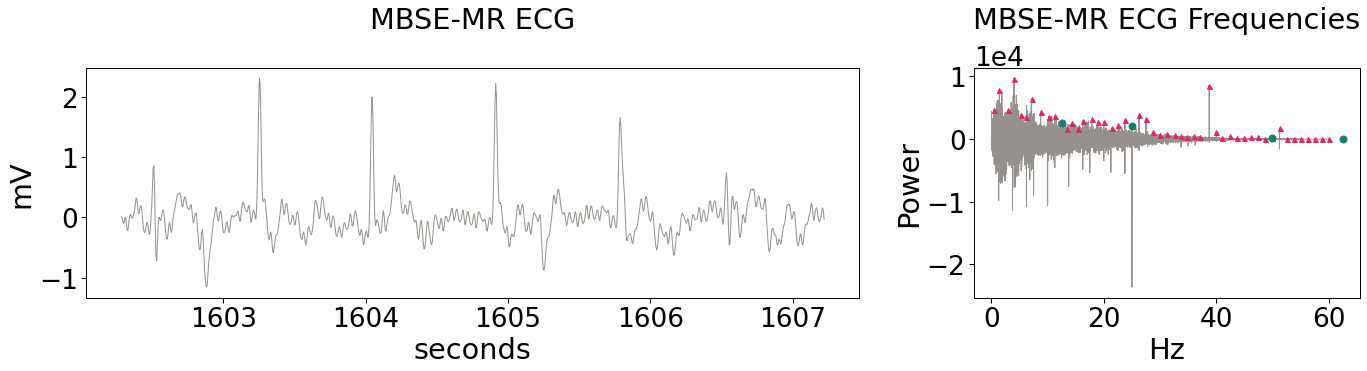

In [11]:
fft_ecg, _, freq, limit = fourier_freq(scan1['ECG'].values, 0.0005, 60)

#find and plot frequencies with highest power  (indicative of MR artifacts)
peaks, _ = signal.find_peaks(fft_ecg.real[:30000], distance=300)
slice_peaks = []
slice_freq = slices / mb / tr
for peak in peaks:
    remainder = np.round(freq[peak],2) % np.round(slice_freq, 2)
    #print(freq[peak], slice_freq, remainder)
    if np.isclose(remainder, 0, atol=1e-2) or np.isclose(remainder, slice_freq, atol=1e-1):
        slice_peaks.append(peak)

plot_signal_fourier(time=scan1['seconds'], 
                    data=scan1['ECG'].values, 
                    downsample=10, 
                    limits=(1000,2000), 
                    fft=fft_ecg, 
                    freq=freq, 
                    lim_fmax=limit, 
                    annotate=True,
                    peaks=peaks,
                    slice_peaks=slice_peaks,
                    title='MBSE-MR ECG', 
                    save=True)

### Step 1B. Magnitude squared coherence between ECG recordings in presence and absence of MR sequence
Physiological data were compared across steps and to data collected in the absence of MR pulse sequences, using magnitude squared coherence to assess linear dependence across the frequency band in which physiologically-relevant signals were found:  0.5 - 50Hz for ECG and <0.5Hz for EDA.

In [12]:
f, Cxy = signal.coherence(scan1['ECG'], 
                          timeseries[timeseries['Trigger'] != 5]['ECG'], 
                          fs=fs, nperseg=2048)

And here's a plot of the frequency bands with biologically relevant cardiac data from ECG.

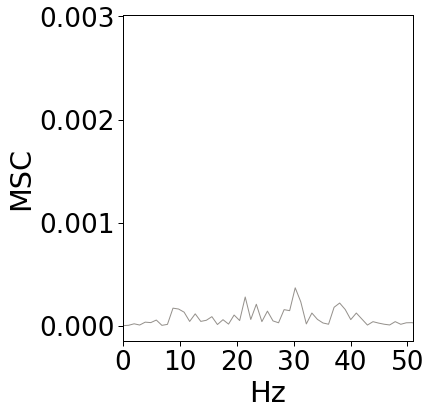

In [13]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1, )
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
ax.set_xlim(0,51)
ax.set_xticks([0,10,20,30,40,50])
plt.show()
fig.savefig('../figures/{0}-scan1-ecgNoMRIXecgRaw.svg'.format(basename))

### Step 2A. Manufacturer-recommended filtering of ECG recording in presence of MR sequence
<a href="www.biopac.com">BIOPAC Systems, Inc.</a>, one of the few manufacturers of MR-compatible equipment for collecting electrophysiological data, includes in their Application Notes a recommendation for removing MR-related artifacts from concurrently collected electrophysiological data. While their MR-specific amplifiers catch much of the noise induced by the MR environment, sequence-specific filtering is required to remove the rest. Their recommendations (devised from data collected during single-band, single-echo fMRI sequences) suggest applying a comb band-stop filter centered at the slice collection frequence (calculated as # slices divided by the TR in seconds) and its harmonics up to the Nyquist frequency. We have applied an equivalent filter here to test this approach's efficacy at removing MR-related artifacts from data collected during a multiband, single-echo fMRI sequence.

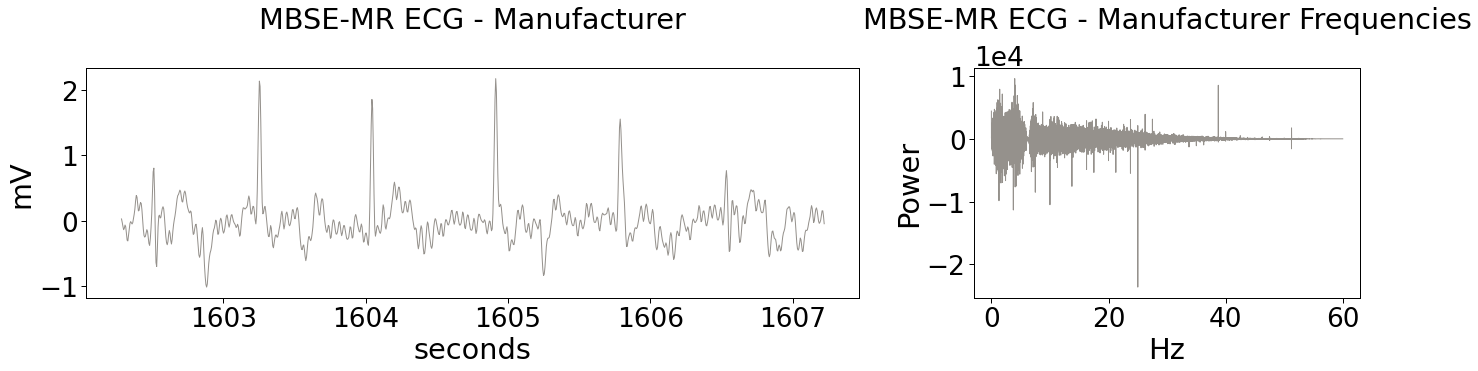

In [14]:
#calculate the slice frequency and apply the filter
notch = slices / tr
biopac_filtered = comb_band_stop(notch, scan1['ECG'], Q, fs)

# apply Fourier transform to inspect frequency spectrum
fft_ecg_bp, _, freq, limit = fourier_freq(biopac_filtered, 0.0005, 60)

# plot the cleaned timeseries and frequency spectrum
plot_signal_fourier(time=scan1['seconds'], 
                    data=biopac_filtered, 
                    downsample=10, 
                    limits=(1000,2000), 
                    fft=fft_ecg_bp, 
                    freq=freq, 
                    lim_fmax=limit, 
                    annotate=False,
                    peaks=None,
                    slice_peaks=None,
                    title='MBSE-MR ECG - Manufacturer', 
                    save=True)

### Step 2B. Magnitude squared coherence between ECG recordings in presence (raw and cleaned) and absence of MR sequence
Physiological data were compared across steps and to data collected in the absence of MR pulse sequences, using magnitude squared coherence to assess linear dependence across the frequency band in which physiologically-relevant signals were found:  0.5 - 50Hz for ECG and <0.5Hz for EDA.

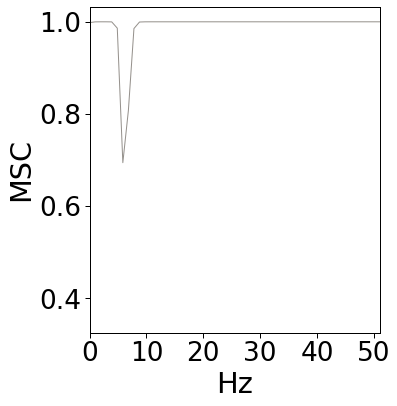

In [15]:
f, Cxy = signal.coherence(scan1['ECG'], biopac_filtered, fs=fs, nperseg=2048)

fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
ax.set_xlim(0,51)
ax.set_xticks([0,10,20,30,40,50])
plt.show()
fig.savefig('../figures/{0}-ecgRawXecgBIOPACClean.svg'.format(basename))

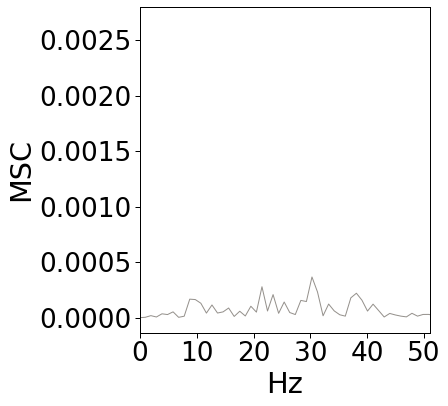

In [16]:
f, Cxy = signal.coherence(timeseries[timeseries['Trigger'] != 5]['ECG'], biopac_filtered, fs=fs, nperseg=2048)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
ax.set_xlim(0,51)
ax.set_xticks([0,10,20,30,40,50])
plt.show()
fig.savefig('../figures/{0}-ecgNoMRIXecgBIOPACClean.svg'.format(basename))

### Step 3A. Update filtering to account for multiband factor and apply to ECG recordings collected during multiband, single-echo EPI sequence.
Based on the identified artifact frequencies, we then adjusted these recommendations to account for the multiband factor of each sequence, with IIR notch filters centered at the frequency corresponding to the number of slices divided by the multiband factor per TR (again, including harmonics) and applied the resultant filter to ECG recordings collected concurrently with multiband, single-echo fMRI sequence.

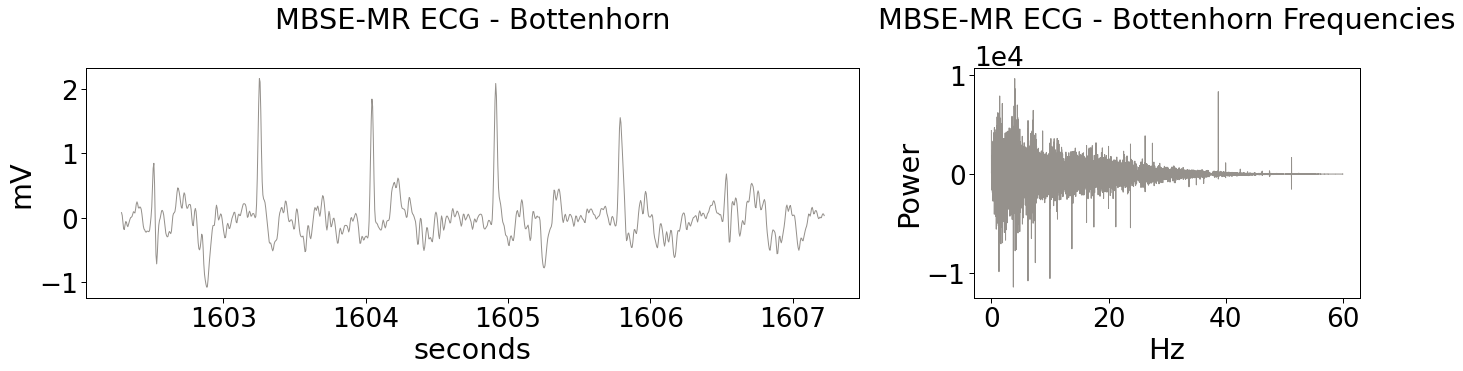

In [17]:
#calculate multiband-updated slice frequency and apply it with a notch filter
notch = slices / mb / tr
bottenhorn_filtered = comb_band_stop(notch, scan1['ECG'], Q, fs)

# apply Fourier transform to inspect frequency spectrum
fft_ecg_bt, _, freq, limit = fourier_freq(bottenhorn_filtered, 0.0005, 60)

# plot the cleaned timeseries and frequency spectrum
plot_signal_fourier(time=scan1['seconds'], 
                    data=bottenhorn_filtered, 
                    downsample=10, 
                    limits=(1000,2000), 
                    fft=fft_ecg_bt, 
                    freq=freq, 
                    lim_fmax=limit, 
                    annotate=False,
                    peaks=None,
                    slice_peaks=None,
                    title='MBSE-MR ECG - Bottenhorn', 
                    save=True)

### Step 3B. Magnitude squared coherence between ECG recordings in presence (raw and cleaned) and absence of multiband, single-echo EPI sequence
Physiological data were compared across steps and to data collected in the absence of MR pulse sequences, using magnitude squared coherence to assess linear dependence across the frequency band in which physiologically-relevant signals were found:  0.5 - 50Hz for ECG and <0.5Hz for EDA.

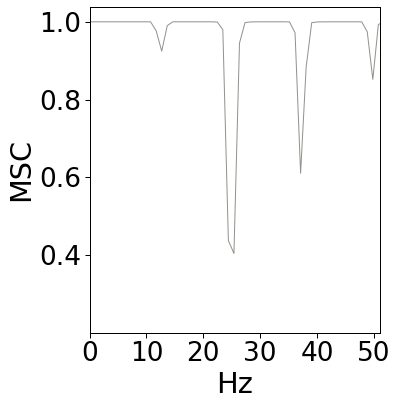

In [18]:
# calculate and plot magnitude squared coherence between raw
# and updated-recommendation-cleaned ECG signals, across cardiovascularly-relevant frequency band

f, Cxy = signal.coherence(scan1['ECG'], bottenhorn_filtered, fs=fs, nperseg=2048)

fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
ax.set_xlim(0,51)
ax.set_xticks([0,10,20,30,40,50])
plt.show()
fig.savefig('../figures/{0}-ecgRawXecgBottenClean.svg'.format(basename))

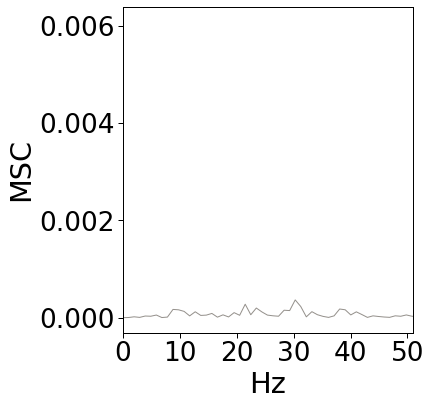

In [19]:
# calculate and plot magnitude squared coherence between no-MR ECG signals
# and updated-recommendation-cleaned ECG signals, across cardiovascularly-relevant frequency band

f, Cxy = signal.coherence(timeseries[timeseries['Trigger'] != 5]['ECG'], bottenhorn_filtered, 
                          fs=fs, nperseg=2048)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
ax.set_xlim(0,51)
ax.set_xticks([0,10,20,30,40,50])
plt.show()
fig.savefig('../figures/{0}-ecgNoMRIXecgBottenClean.svg'.format(basename))

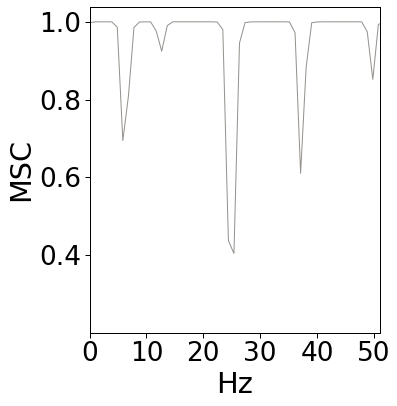

In [20]:
# calculate and plot magnitude squared coherence between manufacturer-recommendation-cleaned
# and updated-recommendation-cleaned ECG signals, across cardiovascularly-relevant frequency band
f, Cxy = signal.coherence(biopac_filtered, bottenhorn_filtered, fs=fs, nperseg=2048)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
ax.set_xlim(0,51)
ax.set_xticks([0,10,20,30,40,50])
plt.show()
fig.savefig('../figures/{0}-ecgBIOPACCleanXecgBottenClean.svg'.format(basename))

## Multiband, multi-echo EPI sequence
The MBME BOLD EPI sequence used here is from the  distribution of multi-band accelerated EPI sequences (Moeller et al., 2010) developed by the Center for Magnetic Resonance Research at the University of Minnesota:
* 48 slices at a 30º transverse-to-coronal orientation with anterior-to-posterior phase encoding direction
* 4 echoes (TE1 = 11.80ms, TE2 = 28.04ms, TE3 = 44.28ms, TE4 = 60.52ms) 
* TR = 1500ms
* MB factor = 3, interleaved acquisition, in-plane GRAPPA acceleration, a 77º flip angle, and an excite pulse duration of 2560µs. 

Participants (n = 4, female, aged 26-39) completed six runs, 6 to 11 minutes each, of film watching (Duffer & Duffer, 2017; NBCLab/Film-Viewing-Task, 2019/2020), two runs of the same emotion regulation task (NBCLab/Eirt-Task, 2020/2020), two runs of a probabilistic selection task, one 6 minutes and the other 9 minutes (Frank et al., 2004), and two runs of 5 minutes of rest.
The full parameters and fMRI data are available on <a href="https://openneuro.org/datasets/ds002278/versions/1.0.1">OpenNeuro.org</a>. 


In [21]:
#arranging noisy frequencies to be filtered out
slices = 48
tr = 1.5
mb = 3
cutoff = 120

fs = 2000.

#I don't know if this is right, been playing around with the value of Q
Q = 100

nyquist = fs/2

In [22]:
data_fname = '../data/raw/mbme-raw.csv'
timeseries = pd.read_csv(data_fname, header=0, index_col=0)
basename = data_fname.split('/')[-1][:-4]
timeseries.head()

/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,ECG,EDA,Trigger,Resp,seconds,scan
0,0.007935,3.964233,0.0,-0.000610,0.0000,NaN
1,0.019836,3.964233,0.0,-0.000305,0.0005,NaN
2,0.033569,3.962708,0.0,0.000000,0.0010,NaN
3,0.046387,3.964233,0.0,0.000000,0.0015,NaN
4,0.060730,3.968811,0.0,0.000305,0.0020,NaN


### Step 0. ECG recording in absence of multiband, multi-echo EPI sequence
First, Fourier transform was applied to ECG and EDA data collected both in the presence (`Trigger == 5`) and absence (`Trigger != 5`) of MR pulse sequences to identify the frequencies of MR-related artifacts.

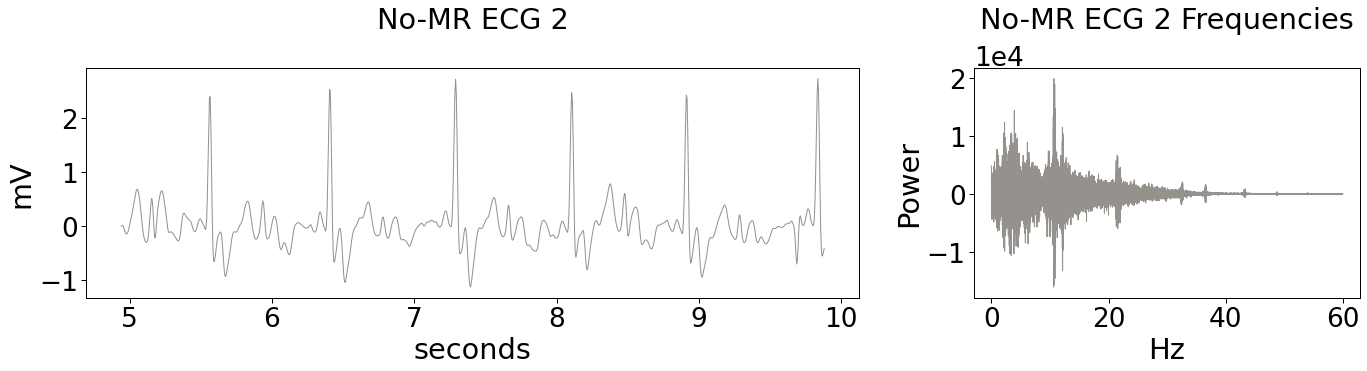

In [23]:
fft_ecg, _, freq, limit = fourier_freq(timeseries[timeseries['Trigger'] != 5]['ECG'][:1000000], 0.0005, 60)
plot_signal_fourier(time=timeseries['seconds'][:200000], 
                    data=timeseries['ECG'][:200000], 
                    downsample=10, 
                    limits=(1000,2000), 
                    fft=fft_ecg, 
                    freq=freq, 
                    lim_fmax=limit, 
                    annotate=False,
                    peaks=None,
                    slice_peaks=None,
                    title='No-MR ECG 2', 
                    save=True)

### Step 1A. ECG recording in absence of multiband, multi-echo EPI sequence
Then, for the purposes of example ECG data collected during the first fMRI scan (`Trigger == 5`) was isolated and Fourier transform was applied to identify the frequencies of MR-related artifacts.

In [24]:
scan1 = timeseries[timeseries['scan'] == 0]

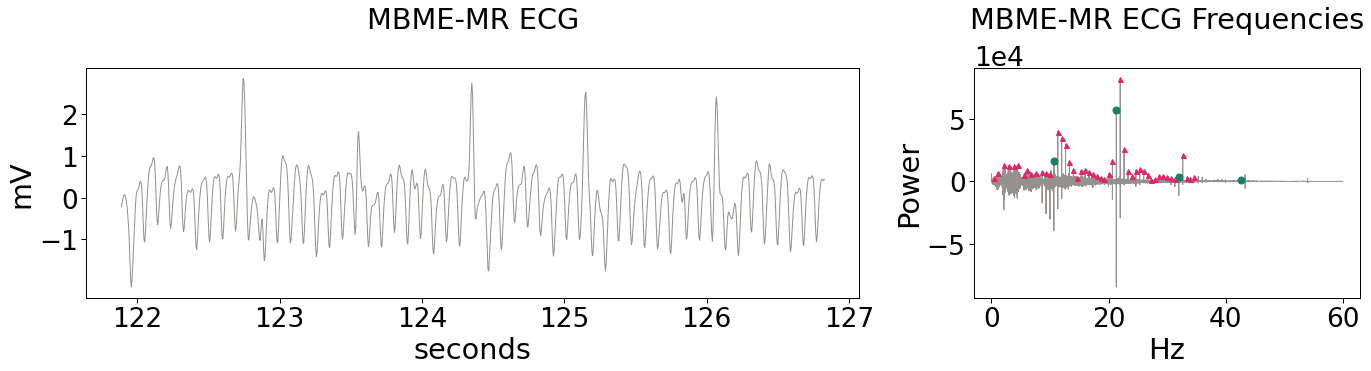

In [25]:
fft_ecg, _, freq, limit = fourier_freq(scan1['ECG'].values, 0.0005, 60)

#find and plot frequencies with highest power  (indicative of MR artifacts)
peaks, _ = signal.find_peaks(fft_ecg.real[:30000], distance=300)
slice_peaks = []
slice_freq = slices / mb / tr
for peak in peaks:
    remainder = np.round(freq[peak],2) % np.round(slice_freq, 2)
    #print(freq[peak], slice_freq, remainder)
    if np.isclose(remainder, 0, atol=1e-2) or np.isclose(remainder, slice_freq, atol=1e-1):
        slice_peaks.append(peak)

plot_signal_fourier(time=scan1['seconds'], 
                    data=scan1['ECG'].values, 
                    downsample=10, 
                    limits=(1000,2000), 
                    fft=fft_ecg, 
                    freq=freq, 
                    lim_fmax=limit, 
                    annotate=True,
                    peaks=peaks,
                    slice_peaks=slice_peaks,
                    title='MBME-MR ECG', 
                    save=True)

### Step 1B. Magnitude squared coherence between ECG recordings in presence and absence of multiband, multiecho EPI sequence
Physiological data were compared across steps and to data collected in the absence of MR pulse sequences, using magnitude squared coherence to assess linear dependence across the frequency band in which physiologically-relevant signals were found:  0.5 - 50Hz for ECG and <0.5Hz for EDA.

In [26]:
f, Cxy = signal.coherence(scan1['ECG'], 
                          timeseries[timeseries['Trigger'] != 5]['ECG'], 
                          fs=fs, nperseg=2048)

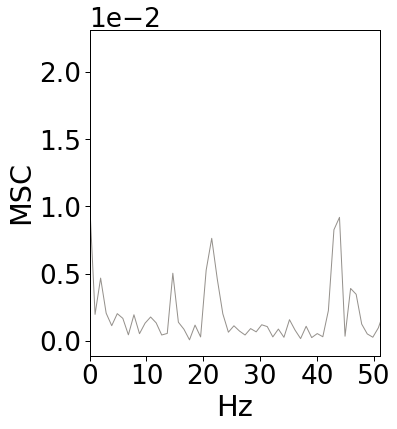

In [27]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
ax.set_xlim(0,51)
ax.set_xticks([0,10,20,30,40,50])
plt.show()
fig.savefig('../figures/{0}-ecgNoMRIXecgRaw.svg'.format(basename))

### Step 2A. Manufacturer-recommended filtering of ECG recording in presence of multiband, multi-echo EPI sequence
<a href="www.biopac.com">BIOPAC Systems, Inc.</a>, one of the few manufacturers of MR-compatible equipment for collecting electrophysiological data, includes in their Application Notes a recommendation for removing MR-related artifacts from concurrently collected electrophysiological data. While their MR-specific amplifiers catch much of the noise induced by the MR environment, sequence-specific filtering is required to remove the rest. Their recommendations (devised from data collected during single-band, single-echo fMRI sequences) suggest applying a comb band-stop filter centered at the slice collection frequence (calculated as # slices divided by the TR in seconds) and its harmonics up to the Nyquist frequency. We have applied an equivalent filter here to test this approach's efficacy at removing MR-related artifacts from data collected during a multiband, multi-echo fMRI sequence.

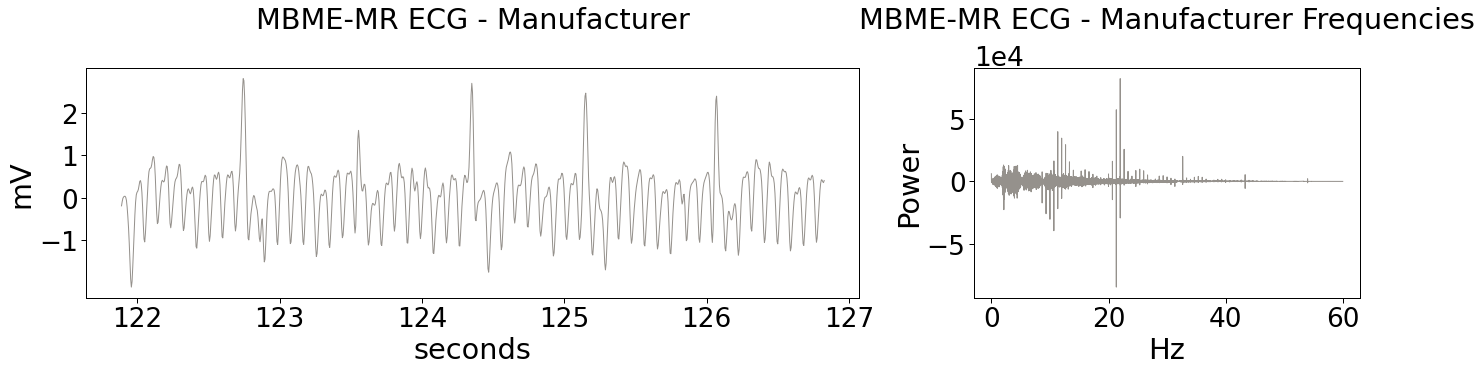

In [28]:
#calculate the slice frequency and apply the filter
notch = slices / tr
biopac_filtered = comb_band_stop(notch, scan1['ECG'], Q, fs)

# apply Fourier transform to inspect frequency spectrum
fft_ecg_bp, _, freq, limit = fourier_freq(biopac_filtered, 0.0005, 60)

# plot the cleaned timeseries and frequency spectrum
plot_signal_fourier(time=scan1['seconds'], 
                    data=biopac_filtered, 
                    downsample=10, 
                    limits=(1000,2000), 
                    fft=fft_ecg_bp, 
                    freq=freq, 
                    lim_fmax=limit, 
                    annotate=False,
                    peaks=None,
                    slice_peaks=None,
                    title='MBME-MR ECG - Manufacturer', 
                    save=True)

### Step 2B. Magnitude squared coherence between ECG recordings in presence (raw and cleaned) and absence of multiband, multi-echo EPI sequence
Physiological data were compared across steps and to data collected in the absence of MR pulse sequences, using magnitude squared coherence to assess linear dependence across the frequency band in which physiologically-relevant signals were found:  0.5 - 50Hz for ECG and <0.5Hz for EDA.

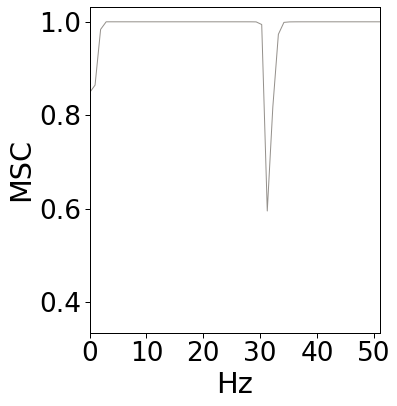

In [29]:
f, Cxy = signal.coherence(scan1['ECG'], biopac_filtered, fs=fs, nperseg=2048)

fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
ax.set_xlim(0,51)
ax.set_xticks([0,10,20,30,40,50])
plt.show()
fig.savefig('../figures/{0}-ecgRawXecgBIOPACClean.svg'.format(basename))

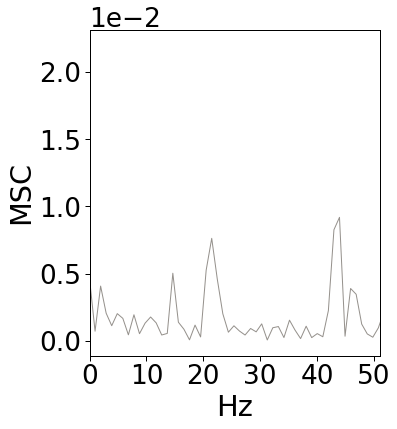

In [30]:
f, Cxy = signal.coherence(timeseries[timeseries['Trigger'] != 5]['ECG'], 
                          biopac_filtered, 
                          fs=fs, nperseg=2048)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
ax.set_xlim(0,51)
ax.set_xticks([0,10,20,30,40,50])
plt.show()
fig.savefig('../figures/{0}-ecgNoMRIXecgBIOPACClean.svg'.format(basename))

### Step 3A. Update filtering to account for multiband factor and apply to ECG recordings collected during multiband, multi-echo EPI sequence.
Based on the identified artifact frequencies, we then adjusted these recommendations to account for the multiband factor of each sequence, with IIR notch filters centered at the frequency corresponding to the number of slices divided by the multiband factor per TR (again, including harmonics). Again, we adjusted the slice collection frequency to account for the multiband factor and applied it as a series of notch filters. Furthermore, potentially due to the increased power of the RF pulse required for acquiring multiple echoes, we observed an artifact frequency of markedly greater power to those seen in the ECG data collected concurrently with the single-echo sequence (above) at the TR frequency. To address this additional artifact, we applied the notch filters centered at the TR frequency (and its harmonics up to Nyquist) to ECG recordings collected concurrently with multiband, multi-echo fMRI sequence.

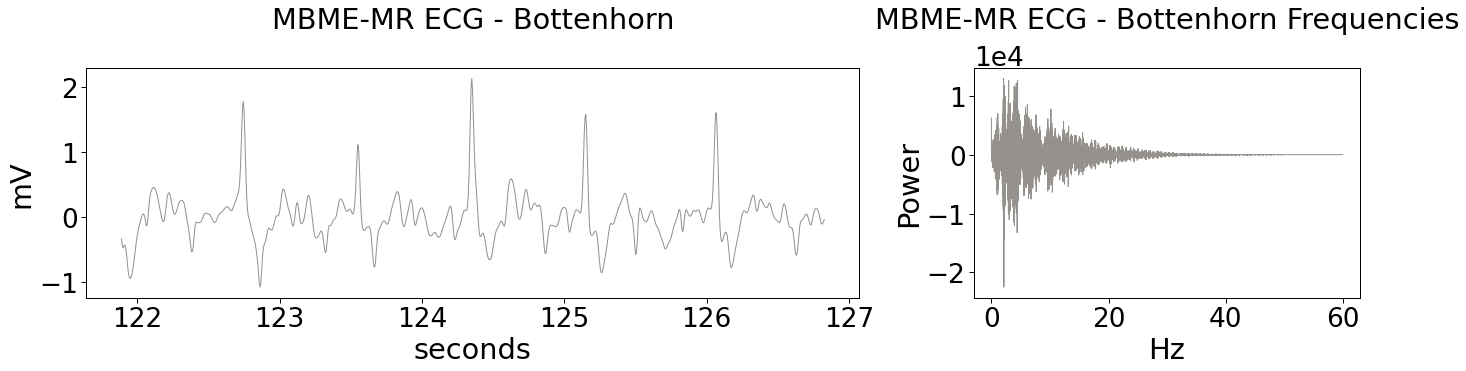

In [31]:
notches = {'slices': slices / mb / tr, 
           'tr': 1 / tr}

#hp_ecg = butter_highpass_filter(scan1['ECG'], 1, fs, order=5)
bottenhorn_filtered = scan1['ECG']
for notch in notches:
    bottenhorn_filtered = comb_band_stop(notches[notch], bottenhorn_filtered, Q, fs)

#calculate the slice frequency and apply the filter

# apply Fourier transform to inspect frequency spectrum
fft_ecg_bt, _, freq, limit = fourier_freq(bottenhorn_filtered, 0.0005, 60)

# plot the cleaned timeseries and frequency spectrum
plot_signal_fourier(time=scan1['seconds'], 
                    data=bottenhorn_filtered, 
                    downsample=10, 
                    limits=(1000,2000), 
                    fft=fft_ecg_bt, 
                    freq=freq, 
                    lim_fmax=limit, 
                    annotate=False,
                    title='MBME-MR ECG - Bottenhorn', 
                    save=True)

### Step 3B. Magnitude squared coherence between ECG recordings in presence (raw and cleaned) and absence of multiband, multi-echo EPI sequence
Physiological data were compared across steps and to data collected in the absence of MR pulse sequences, using magnitude squared coherence to assess linear dependence across the frequency band in which physiologically-relevant signals were found:  0.5 - 50Hz for ECG and <0.5Hz for EDA.

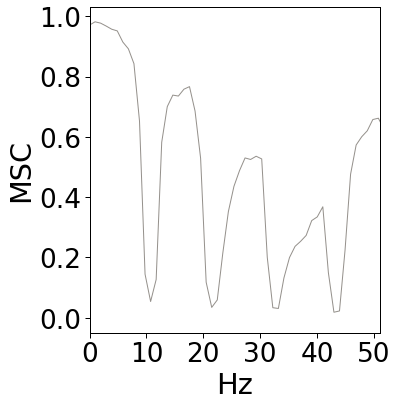

In [32]:
f, Cxy = signal.coherence(scan1['ECG'], bottenhorn_filtered, fs=fs, nperseg=2048)

fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
ax.set_xlim(0,51)
ax.set_xticks([0,10,20,30,40,50])
plt.show()
fig.savefig('../figures/{0}-ecgRawXecgBottenClean.svg'.format(basename))

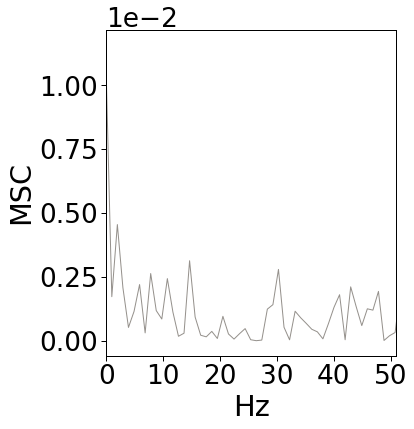

In [33]:
f, Cxy = signal.coherence(timeseries[timeseries['Trigger'] != 5]['ECG'], 
                          bottenhorn_filtered, 
                          fs=fs, nperseg=2048)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
ax.set_xlim(0,51)
ax.set_xticks([0,10,20,30,40,50])
plt.show()
fig.savefig('../figures/{0}-ecgNoMRIXecgBottenClean.svg'.format(basename))

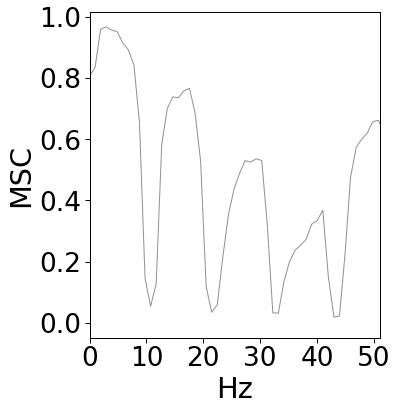

In [34]:
f, Cxy = signal.coherence(biopac_filtered, 
                          bottenhorn_filtered, 
                          fs=fs, nperseg=2048)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f, Cxy, linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
ax.set_xlim(0,51)
ax.set_xticks([0,10,20,30,40,50])
plt.show()
fig.savefig('../figures/{0}-ecgBIOPACCleanXecgBottenClean.svg'.format(basename))